# Условие

$$
u'' - 2u' - u=-2xe^{x}
$$
$$
u(0)=0 
$$
$$
u(1)=e 
$$
$$
u(x) = xe^x
$$

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Vars

In [2]:
a0, b0 = 0, 1
alpha1, alpha2 = 1, 1
gamma1, gamma2 = 0, np.e

In [3]:
N = 2

In [4]:
h = (b0 - a0) / N
h

0.5

In [5]:
X = dict(
    (i - 3, val) for i, val in enumerate(np.linspace(a0 - 3 * h, b0 + 3 * h, N + 7))
)
X

{-3: np.float64(-1.5),
 -2: np.float64(-1.0),
 -1: np.float64(-0.5),
 0: np.float64(0.0),
 1: np.float64(0.5),
 2: np.float64(1.0),
 3: np.float64(1.5),
 4: np.float64(2.0),
 5: np.float64(2.5)}

In [6]:
def p(x):
    return -2


def q(x):
    return -1


def f(x):
    return -2 * x * np.exp(x)

In [7]:
A = np.zeros((N + 3, N + 3))
b = np.zeros(N + 3)

In [8]:
for k in range(0, N + 1):
    A[k + 1, k] = Ak = (1 - p(X[k]) * h / 2 + q(X[k]) * (h**2) / 6) / (3 * h)

    A[k + 1, k + 2] = Dk = (1 + p(X[k]) * h / 2 + q(X[k]) * (h**2) / 6) / (3 * h)

    A[k + 1, k + 1] = -Ak - Dk + q(X[k]) * h / 3

    b[k + 1] = h * f(X[k]) / 3

In [9]:
b[0] = 6 * h * gamma1
b[-1] = 6 * h * gamma2

In [10]:
A[0, 0] = h * alpha1
A[0, 1] = 4 * h * alpha1
A[0, 2] = h * alpha1

A[-1, -1] = h * alpha2
A[-1, -2] = 4 * h * alpha2
A[-1, -3] = h * alpha2

In [11]:
C = np.linalg.solve(A, b)
C = dict((i - 1, val) for i, val in enumerate(C))
C

{-1: np.float64(-0.3187596407091233),
 0: np.float64(-0.07968991017728085),
 1: np.float64(0.6375192814182468),
 2: np.float64(2.3679838059775355),
 3: np.float64(6.20023646542588)}

In [12]:
def B(x, i, X):
    t = (x - X[i]) / h

    if -2 <= t < -1:
        return (t + 2) ** 3
    elif -1 <= t < 0:
        return 1 + 3 * (t + 1) + 3 * (t + 1) ** 2 - 3 * (t + 1) ** 3
    elif 0 <= t < 1:
        return 1 + 3 * (1 - t) + 3 * (1 - t) ** 2 - 3 * (1 - t) ** 3
    elif 1 <= t < 2:
        return (2 - t) ** 3
    
    return 0

# Funcs

In [13]:
def u_approx(x):
    res = 0

    for k in range(-1, N + 2):
        res += C[k] * B(x, k, X)

    return res / 6


def exact_solution(x):
    return x * np.exp(x)

In [14]:
[u_approx(_) for _ in [0, 0.5, 1]]

[np.float64(1.850371707708594e-17),
 np.float64(0.8063951702455402),
 np.float64(2.7182818284590446)]

# Graphs

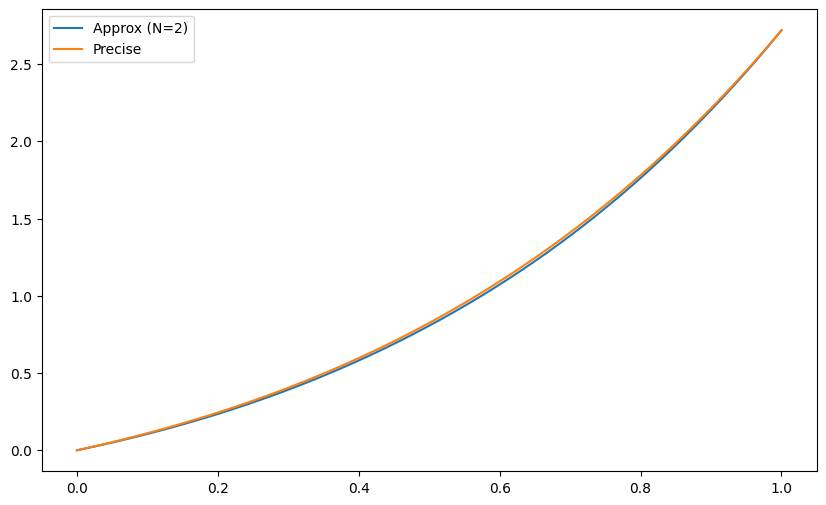

In [15]:
x = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 6))

plt.plot(x, [u_approx(_) for _ in x], label=f"Approx (N={N})")
plt.plot(x, exact_solution(x), label="Precise")

plt.legend()

plt.show()